In [1]:
# General libraries

import sys
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from IPython.display import clear_output

# Own code
sys.path.append("../")
from utils.data_utils import create_data, create_dgp_data, transformation, standardize
from utils.tvp_models import TVPVARModel

# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

# Set RNG
np.random.seed(12345)

In [3]:
train = 178 # 2005Q1

M = 3
p = 4
T = train - p
k = M*(M*p+1)

print(f'k: {k}')

k: 39


In [51]:
X, y, mt1t_true = create_dgp_data(239, M, p)

In [40]:
ds = pd.read_csv("../data/fred_qd.csv")

In [41]:
transform = True

gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform, scale=1)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform, scale=1)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform, scale=1)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform, scale=1)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform, scale=1)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform, scale=1)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform, scale=1)

# Start due to transformation

lag = 2

series_total = [gdp[lag:], cpi[lag:], fedfund[lag:]]
# series_total = [gdp[lag:], cpi[lag:], fedfund[lag:], compi[lag:], borrowings[lag:], sp500[lag:], m2[lag:]]

In [48]:
standardized_series = standardize(series_total, train)

### TVP-VAR with Variational Bayes (VB) - M = 7

In [49]:
complete_T = len(gdp[lag:])
X_complete, y_complete = create_data(series_total,
                                     complete_T,
                                     complete_T-p,
                                     M,
                                     p,
                                     k)

In [46]:
tvp = TVPVARModel(X_complete, y_complete, p, train)
tvp.initialize_priors(prior='horseshoe', prior_parameters={'a0':30,'b0':30})
tvp.train()

Iteration: 60
Elapsed time: 1.413083791732788 seconds
lambda: 0.9013125342947534,phi: 5.011847609068396, v: 1.0383414186092368, delta: 1.0732584899530795 mt1t: 0.22341289595696753
Seconds for one iteration: 0.1473231315612793
Difference: 69.9172620428505
lambda: 0.041434949446861366,phi: 1.9316282459552474, v: 1.0437254083084688, delta: 1.8906279412115323 mt1t: -0.004011164022305491
Seconds for one iteration: 0.14167213439941406
Difference: 69.91726210423244
lambda: 0.9013125345030855,phi: 5.0118476105861625, v: 1.0383414186088777, delta: 1.073258489945158 mt1t: 0.22341289598803782
Seconds for one iteration: 0.14086508750915527
Difference: 69.91726210446606


KeyboardInterrupt: 

In [58]:
tvp = TVPVARModel(X,y,p,train)
tvp.initialize_priors(prior='lasso')
mt1t, __ = tvp.train()

Iteration: 30
Elapsed time: 1.3488271236419678 seconds
Seconds for one iteration: 0.14580106735229492
Difference: 0.00022517503466243306
Seconds for one iteration: 0.14206290245056152
Difference: 0.00017027113388054372
Seconds for one iteration: 0.12946009635925293
Difference: 0.00012889245644239096


In [70]:
def create_dgp_data(T, M, p):
    # Create data
    lagged_y = np.zeros((T, M * p))
    k = M*(M*p+1)

    locations = np.random.randint(0, 10, size=M)
    position_counter = 0

    for m in range(M):
        y_m = np.random.normal(loc=locations[m], scale=2, size=T + p)
        for i in range(1, p + 1):
            lagged_y[:, position_counter] = y_m[(p - i):-i]
            position_counter += 1

    # Create lagged dependent matrix
    X = np.zeros((T, M, k))
    stacked_X = np.zeros((M, T, k))

    for m in range(M):
        total_lags = M * p
        stacked_X[m, :, m * (total_lags):(m + 1) * total_lags] = lagged_y

    stacked_list = list()

    for m in range(M):
        stacked_list.append(stacked_X[m])

    for t in range(T):
        X[t] = np.squeeze(np.dstack(tuple(stacked_list)))[t].T

    # Create betas
    ub = 5
    lb = 0
    difference = 0.5
    scale = 0.010
    sign = -1

    beta = np.zeros((T, k))

    for i in range(k): 
        bound = np.random.randint(lb, ub)

        if sign == 1:
            sign = -1
        else:
            sign = 1

        beta[:, i] = np.linspace(bound, bound + sign * difference, T) + np.random.normal(scale=scale, size=T)

        # beta[:,27:32] = 0
        beta[50:125, 2] = 0

    # Construct dependent
    y = np.zeros((M, T))

    for i in range(T):
        y[:, i] = X[i] @ beta[i] + np.random.normal(
            size=M).T  # np.random.multivariate_normal(mean=np.zeros(2), cov=np.diag([0.10,5]))

    # Transpose for KF
    y = y.T

    return X, y, beta

0.81983370111055

In [149]:
def create_dgp_data(T, M, p):
    k = M*(M*p+1)
    
    locations = np.random.randint(0, 100, size=M)
    position_counter = 0
    
    # Create betas
    ub = 5
    lb = 0
    difference = 0.5
    scale = 0.010
    sign = -1

    beta = np.zeros((T, k))

    for i in range(k): 
        bound = np.random.randint(lb, ub)

        if sign == 1:
            sign = -1
        else:
            sign = 1

        beta[:, i] = np.linspace(bound, bound + sign * difference, T) + np.random.normal(scale=scale, size=T)
        
    # Construct dependent
    y = np.zeros((M, T))
    
    for i in range(T):
        y[:, i] = X[i] @ beta[i] + np.random.normal(size=M).T
    
    

In [174]:
locations = np.random.randint(0, 10, size=M)
initial_y = np.random.multivariate_normal(mean=locations,cov=np.diag([1,1,1]),size=p)
y_constant = np.hstack(([1],initial_y.flatten('F')))

In [335]:
y = np.zeros((T+p,M))

y[:p] = initial_y = np.random.multivariate_normal(mean=locations,cov=np.diag([1,1,1]),size=p)

k = M*(M*p)

for t in range(p,T+p):

    X = np.zeros((M, k))
    stacked_X = np.zeros((M, k))

    for m in range(M):
        total_lags = M * p 
        stacked_X[m, m * (total_lags):(m + 1) * total_lags] = y[t-p:t].flatten('F')
        
    y[t,:] = beta[t-p,:]@stacked_X.T

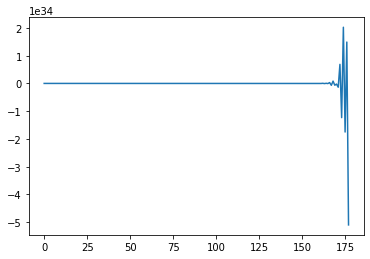

In [336]:
plt.plot(y[:,2])

In [72]:
locations = np.random.randint(0, 100, size=M)

In [230]:
initial_y = np.random.multivariate_normal(mean=locations,cov=np.diag([1,1,1]),size=p)

# Create betas
ub = 1
lb = 0
p = 0.5
difference = 0.5
scale = 0.010
sign = -1

beta = np.zeros((T, k))

for i in range(k): 
    bound = np.random.ranf()*0.15

    if sign == 1:
        sign = -1
    else:
        sign = 1

    beta[:, i] = np.linspace(bound, bound + sign * difference, T) + np.random.normal(scale=scale, size=T)

In [333]:
new_k = M*(M*p)
beta = np.zeros((T,new_k))

for i in range(T):
    
    beta[i] = beta[i-1] + np.random.multivariate_normal(mean=np.zeros(new_k), cov=np.diag(np.ones(new_k)*0.01),size=1)

In [334]:
beta[:,0]

array([-0.00585739, -0.16473618, -0.24704648, -0.20064183, -0.34193688,
       -0.18372427, -0.16302984, -0.33483663, -0.33203415, -0.28290002,
       -0.19368138, -0.30732507, -0.29722012, -0.20131118, -0.19039556,
       -0.22605881, -0.28894292, -0.29623683, -0.20019907, -0.17431602,
       -0.2005662 , -0.19717134, -0.15194246, -0.25693848, -0.25399012,
       -0.18590617, -0.04193357,  0.05403411,  0.04465792,  0.02067898,
        0.02615436, -0.20113317, -0.13734634,  0.01966056,  0.05438007,
       -0.05818185, -0.00074293, -0.15267708, -0.05680949, -0.05134714,
        0.14059281,  0.07670372,  0.49817287,  0.48780791,  0.40881085,
        0.30223009,  0.30549371,  0.19722182,  0.2541699 ,  0.38957388,
        0.38077488,  0.17264375,  0.21978121,  0.29433114,  0.11956846,
        0.16707734, -0.0275939 ,  0.05563677,  0.02605384,  0.1809755 ,
        0.1431217 ,  0.35364647,  0.275729  ,  0.14091371,  0.0932318 ,
        0.10457151,  0.00907655, -0.01419565,  0.06144651,  0.21

In [ ]:
# SVSS
# Optimizing the shrinkage for M = 7 (default values are optimal for M = 3)

# tau_0 = np.arange(0.5, 5, 1)
# tau_1 = np.arange(100, 300, 50)

tau_0 = np.arange(0.5, 5, 1)
tau_1 = np.arange(10, 100, 15)

train_gridsearch = 98 #1985Q4

parameter_set = []

for t_0 in tau_0:
    for t_1 in tau_1:
        parameter_set.append((t_0, t_1))

msfe_list = []
number_of_possibilities = len(parameter_set)
print(f'Number of possibilities: {number_of_possibilities}')

for idx, p_set in enumerate(parameter_set):
    
    tau_0, tau_1 = p_set
    
    tvp_svss = TVPVARModel(X_complete, y_complete, p, train)
    tvp_svss.initialize_priors(prior='svss',
                               prior_parameters={'tau_0': tau_0,
                                                 'tau_1': tau_1,
                                                 'pi0': 0.5},
                               )
    
    mt1t, St1t = tvp_svss.train(print_status=False)
    msfe_list.append(tvp_svss.insample_msfe())
    
    print(f'Progress: {(idx+1)}/{number_of_possibilities}')
    
# Clear printing output
clear_output()
    
sorted_indices = np.argsort(msfe_list)

for i in range(number_of_possibilities):
    
    sorted_index = sorted_indices[i]
    
    print(f'MSFE: {msfe_list[sorted_index]} | '
          f'tau_0: {parameter_set[sorted_index][0]} & '
          f'tau_1: {parameter_set[sorted_index][1]}')
    
    
optimal_svss = parameter_set[sorted_indices[0]]

In [ ]:
# Horseshoe
# Optimizing the shrinkage for M = 7 (default values are optimal for M = 3)

a0_horseshoe = np.arange(10, 30, 5)
b0_horseshoe = np.arange(10, 30, 5)

train_gridsearch = 98 # 1985Q1

parameter_set = []

for a0 in a0_horseshoe:
    for b0 in b0_horseshoe:
        parameter_set.append((a0, b0))

msfe_list = []
number_of_possibilities = len(parameter_set)
print(f'Number of possibilities: {number_of_possibilities}')

for idx, p_set in enumerate(parameter_set):
    
    a0, b0 = p_set
    
    tvp_horseshoe = TVPVARModel(X_complete, y_complete, p, train_gridsearch)
    tvp_horseshoe.initialize_priors(prior='horseshoe',
                               prior_parameters={'a0': a0,
                                                 'b0': b0})
    
    mt1t, St1t = tvp_horseshoe.train(print_status=False)
    msfe_list.append(tvp_horseshoe.insample_msfe())
    
    print(f'Progress: {(idx+1)}/{number_of_possibilities}')
    
# Clear printing output
clear_output()
    
sorted_indices = np.argsort(msfe_list)

for i in range(number_of_possibilities):
    
    sorted_index = sorted_indices[i]
    
    print(f'MSFE: {msfe_list[sorted_index]} | '
          f'a0: {parameter_set[sorted_index][0]} & '
          f'b0: {parameter_set[sorted_index][1]}')
    
optimal_horseshoe = parameter_set[sorted_indices[0]]

In [ ]:
# Lasso
# Optimizing the shrinkage for M = 7 (default values are optimal for M = 3)

lambda_parameters = np.arange(10, 200, 25)

train_gridsearch = 98 #1985Q4

parameter_set = []

for lambda_param in lambda_parameters:
    parameter_set.append((lambda_param))

msfe_list = []
number_of_possibilities = len(parameter_set)
print(f'Number of possibilities: {number_of_possibilities}')

for idx, p_set in enumerate(parameter_set):
    
    lambda_param = p_set
    
    tvp_lasso = TVPVARModel(X_complete, y_complete, p, train_gridsearch)
    tvp_lasso.initialize_priors(prior='lasso',
                               prior_parameters={'lambda_param': lambda_param})
    
    mt1t, St1t = tvp_lasso.train(print_status=False)
    msfe_list.append(tvp_lasso.insample_msfe())
    
    print(f'Progress: {(idx+1)}/{number_of_possibilities}')
    
# Clear printing output
clear_output()
    
sorted_indices = np.argsort(msfe_list)

for i in range(number_of_possibilities):
    
    sorted_index = sorted_indices[i]
    
    print(f'MSFE: {msfe_list[sorted_index]} | '
          f'lambda: {parameter_set[sorted_index]}')
    
optimal_lambda = parameter_set[sorted_indices[0]]

In [ ]:
# SVSS
# Calculate h-step forecasts (h = 1 .. 8) for M = 7

# optimal_svss = (4.5, 250) #M = 7
optimal_svss = (1.5, 70)

tvp_svss = TVPVARModel(X_complete, y_complete, p, train)
tvp_svss.initialize_priors(prior='svss',
                           prior_parameters={'tau_0': optimal_svss[0],
                                             'tau_1': optimal_svss[1],
                                             'pi0':0.5})

h_forecast = 8

msfe_svss, alpl_svss = tvp_svss.calculate_metrics(h_forecast)

clear_output()
print(f'MSFE for SVSS:')
print(np.mean(msfe_svss,1))

In [ ]:
# Horseshoe
# Calculate h-step forecasts (h = 1 .. 8) for M = 7

optimal_horseshoe = (25,10)

tvp_horseshoe = TVPVARModel(X_complete, y_complete, p, train)
tvp_horseshoe.initialize_priors(prior='horseshoe',
                            prior_parameters={'a0': optimal_horseshoe[0],
                                              'b0': optimal_horseshoe[1]})

tvp_horseshoe.print_status = False

h_forecast = 8

msfe_horseshoe, alpl_horseshoe = tvp_horseshoe.calculate_metrics(h_forecast)

clear_output()
print(f'MSFE for Horseshoe:')
print(np.mean(msfe_horseshoe,1))

In [ ]:
for i in range(8):
    
    np.savetxt(f'../rcode/horseshoe_{i+1}.csv', tvp_horseshoe.y_pred[:,:,i], delimiter=",")

In [50]:
tvp_svss = TVPVARModel(X_complete, y_complete, p, train, 200)
tvp_svss.initialize_priors(prior='horseshoe')
__, __ = tvp_svss.train(print_status=True)

Iteration: 0
Elapsed time: 0 seconds
lambda: 0.33034885030248745,phi: 2.1988491905256105, v: 1.1341038279442246, delta: 1.4478288295656339 mt1t: 0.006915187720900422
Seconds for one iteration: 0.15065383911132812
Difference: 82.37718130647589
lambda: 0.09272736825971865,phi: 1.7962611057246485, v: 1.1455866315521606, delta: 2.355596022497353 mt1t: -0.00442778581445894
Seconds for one iteration: 0.14159178733825684
Difference: 8.401025334569521
lambda: 0.09780235336436652,phi: 1.7775330955236566, v: 1.1463039991966182, delta: 2.2814590108942734 mt1t: -0.007982887679353127
Seconds for one iteration: 0.13572096824645996
Difference: 22.00002597909927
lambda: 0.09523138867046976,phi: 1.774372740860882, v: 1.1464281297548669, delta: 2.3155516514263454 mt1t: -0.007728416209869795
Seconds for one iteration: 0.1368408203125
Difference: 4.586930227112368
lambda: 0.09523243656305909,phi: 1.7741827375060077, v: 1.1464356370574702, delta: 2.315744906831839 mt1t: -0.007738449990095723
Seconds for on

In [ ]:
# Lasso
# Calculate h-step forecasts (h = 1 .. 8) for M = 7

tvp_lasso = TVPVARModel(X_complete, y_complete, p, train)
tvp_lasso.initialize_priors(prior='lasso',
                            prior_parameters={'lambda_param': optimal_lambda})

h_forecast = 8

msfe_lasso, alpl_lasso = tvp_lasso.calculate_metrics(h_forecast)

clear_output()
np.mean(msfe_lasso, 1)

In [ ]:
tvp = TVPVARModel(X_complete, y_complete, p, train)

In [ ]:
import pickle

dump_to_disk = (msfe_horseshoe, alpl_horseshoe, msfe_lasso,
                alpl_lasso, optimal_svss, optimal_horseshoe, optimal_lambda)

with open('dumps/mse_alpl_7_non_standard_horseshoe_lasso.pkl', 'wb') as f:
    pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
np.mean(msfe_horseshoe,1)

In [ ]:
import pickle

dump_to_disk = (msfe_horseshoe, alpl_horseshoe, optimal_horseshoe)

with open('dumps/mse_alpl_7_non_standard_horseshoe.pkl', 'wb') as f:
    pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# SVSS
# Calculate h-step forecasts (h = 1 .. 8) for M = 7

# optimal_svss = (4.5, 250) #M = 7
optimal_svss = (1.5, 70)

tvp_svss = TVPVARModel(X_complete, y_complete, p, train)
tvp_svss.initialize_priors(prior='svss',
                           prior_parameters={'tau_0': optimal_svss[0],
                                             'tau_1': optimal_svss[1],
                                             'pi0':0.5})

h_forecast = 1

msfe_svss, alpl_svss = tvp_svss.calculate_metrics(h_forecast)

clear_output()
print(f'MSFE for SVSS:')
print(np.mean(msfe_svss,1))

In [ ]:
def calculate_derivative_svss_tau_0(parameter_values, h_forecast):
    
    error = np.sqrt(1.1e-16)
    tvp_plus = TVPVARModel(X_complete, y_complete, p, train)
    tvp_minus = TVPVARModel(X_complete, y_complete, p, train)
    
    tvp_plus.initialize_priors(prior='svss', prior_parameters={'tau_0':parameter_values['tau_0']+error,'tau_1':parameter_values['tau_1'],'pi0':parameter_values['pi0']})
    tvp_minus.initialize_priors(prior='svss', prior_parameters={'tau_0':parameter_values['tau_0']-error,'tau_1':parameter_values['tau_1'],'pi0':parameter_values['pi0']})
    
    msfe_svss_plus, __ = tvp_plus.calculate_metrics(h_forecast, print_status=False)
    msfe_svss_minus, __ = tvp_minus.calculate_metrics(h_forecast, print_status=False)
    
    derivative = (msfe_svss_plus[0][0] - msfe_svss_minus[0][0])/(2*error)
    print(f'plus: {msfe_svss_plus[0][0]} | minus: {msfe_svss_minus[0][0]}')
    
    return derivative

In [ ]:
%%time

tau_0_set = np.arange(1.5,10,0.25)

derivatives = np.zeros(tau_0_set.shape[0], dtype=np.float64)

for i, tau_0 in enumerate(tau_0_set):
    
    derivatives[i] = calculate_derivative_svss_tau_0({'tau_0':tau_0,'tau_1':70,'pi0':0.5}, 1)
    print(f'{i+1}/{tau_0_set.shape[0]} - derivative: {derivatives[i]}')
    
dump_to_disk = (tau_0_set, derivatives)
    
with open('dumps/derivatives_svss_tau_0.pkl', 'wb') as f:
    pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def calculate_derivative_svss_tau_1(parameter_values, h_forecast):
    
    error = np.sqrt(1.1e-16)
    tvp_plus = TVPVARModel(X_complete, y_complete, p, train)
    tvp_minus = TVPVARModel(X_complete, y_complete, p, train)
    
    tvp_plus.initialize_priors(prior='svss', prior_parameters={'tau_0':parameter_values['tau_0'],'tau_1':parameter_values['tau_1']+error,'pi0':parameter_values['pi0']})
    tvp_minus.initialize_priors(prior='svss', prior_parameters={'tau_0':parameter_values['tau_0'],'tau_1':parameter_values['tau_1']-error,'pi0':parameter_values['pi0']})
    
    msfe_svss_plus, __ = tvp_plus.calculate_metrics(h_forecast, print_status=False)
    msfe_svss_minus, __ = tvp_minus.calculate_metrics(h_forecast, print_status=False)
    
    derivative = (msfe_svss_plus[0][0] - msfe_svss_minus[0][0])/(2*error)
    print(f'plus: {msfe_svss_plus[0][0]} | minus: {msfe_svss_minus[0][0]}')
    
    return derivative

In [ ]:
%%time

import pickle

tau_1_set = np.arange(70,80,0.25)

derivatives = np.zeros(tau_1_set.shape[0], dtype=np.float64)

for i, tau_1 in enumerate(tau_1_set):
    derivatives[i] = calculate_derivative_svss_tau_1({'tau_0':1.5,'tau_1':tau_1,'pi0':0.5}, 1)
    print(f'{i+1}/{tau_1_set.shape[0]} - derivative: {derivatives[i]}')
    
dump_to_disk = (tau_1_set, derivatives)
    
with open('dumps/derivatives_svss_tau_1.pkl', 'wb') as f:
    pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

In [7]:
tvp = TVPVARModel(X_complete, y_complete, p, train)
tvp.initialize_priors(prior='svss', prior_parameters={'tau_0':2.5,'tau_1':100, 'pi0':0.5})

In [19]:
tvp.insample_msfe()

0.0005257996901390391

In [20]:
tvp.insample_msfe()

0.0005257996901390391

In [ ]:
tvp.prior_parameters

In [16]:
def calculate_derivatives(prior, prior_parameters, parameter_id):
    
    h_forecast = 1
    msfe_list = np.zeros(2)
    error = np.sqrt(1.1e-16)
    for i in range(2):
        changed_parameter = prior_parameters.get(parameter_id)
        if i == 0:
            changed_parameter += error
        else:
            changed_parameter -= error
        prior_parameters.pop(parameter_id)
        prior_parameters.update({parameter_id: changed_parameter})
        tvp = TVPVARModel(X_complete, y_complete, p, train)
        tvp.initialize_priors(prior=prior, prior_parameters=prior_parameters)
        msfe, __ = tvp.calculate_metrics(h_forecast, print_status=False)
        msfe_list[i] = msfe[0][0]
        
    derivative = (msfe_list[0] - msfe_list[1])/(2*error)
    return derivative

In [ ]:
%%time

tau_0_set = np.arange(1.5,10,0.25)

derivatives = np.zeros(tau_0_set.shape[0], dtype=np.float64)

for i, tau_0 in enumerate(tau_0_set):
    
    derivatives[i] = calculate_derivatives(prior='svss',
                                           prior_parameters={'tau_0':tau_0,'tau_1':70,'pi0':0.5},
                                           parameter_id='tau_0',
                                           h_forecast=1)
    print(f'{i+1}/{tau_0_set.shape[0]} - derivative: {derivatives[i]}')
    
dump_to_disk = (tau_0_set, derivatives)

In [ ]:
%%time

param_set = np.arange(25,35,0.25)

derivatives = np.zeros(param_set.shape[0], dtype=np.float64)

for i, param in enumerate(param_set):
    
    derivatives[i] = calculate_derivatives(prior='horseshoe',
                                           prior_parameters={'a0':param,'b0':10},
                                           parameter_id='a0',
                                           h_forecast=1)
    print(f'{i+1}/{param_set.shape[0]} - derivative: {derivatives[i]}')
    
dump_to_disk = (tau_0_set, derivatives)

In [20]:
%%time

param_set = np.arange(100,150,1)

derivatives = np.zeros(param_set.shape[0], dtype=np.float64)

for i, param in enumerate(param_set):
    
    derivatives[i] = calculate_derivatives(prior='lasso',
                                           prior_parameters={'lambda_param': param},
                                           parameter_id='lambda_param')
    print(f'{i+1}/{param_set.shape[0]} - derivative: {derivatives[i]}')
    
dump_to_disk = (param_set, derivatives)

1/50 - derivative: -2.707122889123256e-09
2/50 - derivative: -2.8240654292023273e-09
3/50 - derivative: -2.9481149744795744e-09
4/50 - derivative: -3.0850863473898678e-09
5/50 - derivative: -3.203967161613896e-09
6/50 - derivative: -3.4023172157811612e-09
7/50 - derivative: -3.5522104163245014e-09
8/50 - derivative: -3.610358640673211e-09
9/50 - derivative: -3.6413710269925227e-09
10/50 - derivative: -3.6865974237081855e-09
11/50 - derivative: -3.768004937796379e-09
12/50 - derivative: -3.616173463108082e-09
13/50 - derivative: -3.7486221963468095e-09
14/50 - derivative: -3.788033770627601e-09
15/50 - derivative: -3.836490624251526e-09
16/50 - derivative: -3.882363112348841e-09
17/50 - derivative: -3.795786867207429e-09
18/50 - derivative: -3.693704428906361e-09
19/50 - derivative: -3.733762094568806e-09
20/50 - derivative: -3.797079049970734e-09
21/50 - derivative: -3.8687951933341425e-09
22/50 - derivative: -3.88494747787545e-09
23/50 - derivative: -3.911437224523196e-09
24/50 - deri

KeyboardInterrupt: 

In [21]:
with open('dumps/derivatives_lasso.pkl', 'wb') as f:
    pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

NameError: name 'dump_to_disk' is not defined

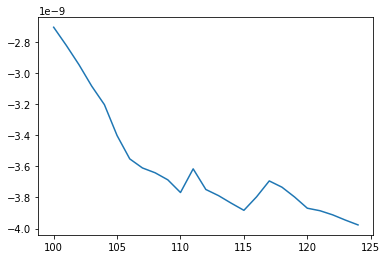

In [22]:
plt.plot(param_set[:25], derivatives[:25])